## License Plate Detection Using YoloV8

### For Video Processing

In [5]:
from ultralytics import YOLO
import cv2
import util
from sort.sort import *
from util import get_car, read_license_plate, write_csv

# Set the GPU device
# import torch
# torch.cuda.set_device(0) # Set to your desired GPU number

results = {}

mot_tracker = Sort()

# Load YOLO models
coco_model = YOLO('yolo_models/yolov8n.pt')
license_plate_detector = YOLO('yolo_models/license_plate_detector.pt')

In [ ]:
# load video
cap = cv2.VideoCapture('pexels_videos_2103099 (1080p).mp4')

vehicles = [2, 3, 5, 7]

# read frames
frame_nmr = -1
ret = True
while ret:
    frame_nmr += 1
    ret, frame = cap.read()
    if ret:
        results[frame_nmr] = {}
        # detect vehicles
        detections = coco_model(frame)[0]
        detections_ = []
        for detection in detections.boxes.data.tolist():
            x1, y1, x2, y2, score, class_id = detection
            if int(class_id) in vehicles:
                detections_.append([x1, y1, x2, y2, score])

        # track vehicles
        track_ids = mot_tracker.update(np.asarray(detections_))

        # detect license plates
        license_plates = license_plate_detector(frame)[0]
        for license_plate in license_plates.boxes.data.tolist():
            x1, y1, x2, y2, score, class_id = license_plate

            # assign license plate to car
            xcar1, ycar1, xcar2, ycar2, car_id = get_car(license_plate, track_ids)

            if car_id != -1:
                # crop license plate from the original image
                license_plate_crop_original = frame[int(y1):int(y2), int(x1):int(x2), :]

                # Save the license plate with the same resolution as the original input image
                output_path = f"Datasets/pexels_video/license_plate_{frame_nmr}_{car_id}.jpg"
                cv2.imwrite(output_path, license_plate_crop_original)


0: 384x640 20 cars, 1 bus, 2 trucks, 71.2ms
Speed: 7.2ms preprocess, 71.2ms inference, 4.8ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 license_plates, 61.8ms
Speed: 3.2ms preprocess, 61.8ms inference, 3.6ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 22 cars, 1 bus, 2 trucks, 68.1ms
Speed: 4.1ms preprocess, 68.1ms inference, 4.7ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 license_plates, 60.9ms
Speed: 4.0ms preprocess, 60.9ms inference, 5.3ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 22 cars, 1 bus, 2 trucks, 68.8ms
Speed: 6.4ms preprocess, 68.8ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 license_plates, 60.3ms
Speed: 3.9ms preprocess, 60.3ms inference, 6.4ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 24 cars, 1 bus, 3 trucks, 68.2ms
Speed: 5.0ms preprocess, 68.2ms inference, 3.9ms postprocess per image at shape (1, 3, 640, 640)

0: 384x640 2 license_plates, 

### For Image Processing

In [6]:
from ultralytics import YOLO
import cv2
from sort.sort import *
from util import get_car

# Set the GPU device
# import torch
# torch.cuda.set_device(0) # Set to your desired GPU number

# Load YOLO models
coco_model = YOLO('yolo_models/yolov8n.pt')
license_plate_detector = YOLO('yolo_models/license_plate_detector.pt')

# Initialize SORT tracker
mot_tracker = Sort()

def process_image(image):
    # detect vehicles
    detections = coco_model(image)[0]
    detections_ = []
    for detection in detections.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = detection
        # Considering only certain classes as vehicles
        vehicles = [2, 3, 5, 7]
        if int(class_id) in vehicles:
            detections_.append([x1, y1, x2, y2, score])

    # track vehicles
    track_ids = mot_tracker.update(np.asarray(detections_))

    # detect license plates
    license_plates = license_plate_detector(image)[0]
    license_plate_results = []
    lp_crop = None
    for license_plate in license_plates.boxes.data.tolist():
        x1, y1, x2, y2, score, class_id = license_plate
        
        # crop license plate from the original image
        license_plate_crop_original = image[int(y1):int(y2), int(x1):int(x2), :]
        lp_crop = license_plate_crop_original
        # assign license plate to car
        xcar1, ycar1, xcar2, ycar2, car_id = get_car(license_plate, track_ids)
        
        if car_id != -1:
            license_plate_results.append((car_id, license_plate_crop_original))
        else:
            continue

    return license_plate_results, lp_crop

In [34]:
# Process the image
img = cv2.imread('download.jpeg')
lp_results, lp_img_crop = process_image(img)


0: 480x640 1 train, 252.5ms
Speed: 5.1ms preprocess, 252.5ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 license_plate, 264.5ms
Speed: 9.0ms preprocess, 264.5ms inference, 3.0ms postprocess per image at shape (1, 3, 480, 640)


## Character Segmentation

### Finding the License Plate Characters

In [8]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import statistics as st
%matplotlib inline

def find_contours(dimensions, img):
    # Find all contours in the image
    cntrs, _ = cv2.findContours(img.copy(), cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    # Retrieve potential dimensions
    lower_width = dimensions[0]
    upper_width = dimensions[1]
    lower_height = dimensions[2]
    upper_height = dimensions[3]

    # Check largest 5 or 15 contours for license plate or character respectively
    cntrs = sorted(cntrs, key=cv2.contourArea, reverse=True)[:15]

    ii = cv2.imread('contour.jpg')

    x_cntr_list = []
    img_res = []
    widths = []
    heights = []
    contours = []  # Store contour coordinates here

    # Calculate the middle line of the license plate
    middle_line = img.shape[0] // 2

    # Sort contours based on x-coordinate and then on y-coordinate
    sorted_cntrs = sorted(cntrs, key=lambda c: (c[0][0][0], c[0][0][1]))

    # Separate contours above and below the middle line
    above_middle = []
    below_middle = []
    for cntr in sorted_cntrs:
        x, y, w, h = cv2.boundingRect(cntr)

        if y < middle_line:
            above_middle.append((x, y, w, h, cntr))
        else:
            below_middle.append((x, y, w, h, cntr))

    # Sort contours from left to right
    above_middle = sorted(above_middle, key=lambda c: c[0])
    below_middle = sorted(below_middle, key=lambda c: c[0])

    # Process contours above the middle line
    for x, y, w, h, cntr in above_middle:
        if w > lower_width and w < upper_width and h > lower_height and h < upper_height:
            char = img[y:y+h, x:x+w]
            white_pixels = np.sum(char == 255)
            total_pixels = char.size
            white_percentage = (white_pixels / total_pixels) * 100

            if white_percentage >= 25:
                x_cntr_list.append((x, y))  # stores the (x, y) coordinates of the character's contour
                widths.append(w)
                heights.append(h)
                contours.append((x, y, x+w, y+h))  # Append contour coordinates
                
                char_copy = np.zeros((44, 24))
                # Extracting each character using the enclosing rectangle's coordinates.
                char = cv2.resize(char, (20, 40))

                cv2.rectangle(ii, (x, y), (x+w, y+h), (50, 21, 200), 2)
                plt.imshow(ii, cmap='gray')

                # Make result formatted for classification: invert colors
                char = cv2.subtract(255, char)

                # Resize the image to 24x44 with a black border
                char_copy[2:42, 2:22] = char
                char_copy[0:2, :] = 0
                char_copy[:, 0:2] = 0
                char_copy[42:44, :] = 0
                char_copy[:, 22:24] = 0

                img_res.append(char_copy)  # List that stores the character's binary image (unsorted)

    # Process contours below the middle line
    for x, y, w, h, cntr in below_middle:
        if w > lower_width and w < upper_width and h > lower_height and h < upper_height:
            char = img[y:y+h, x:x+w]
            white_pixels = np.sum(char == 255)
            total_pixels = char.size
            white_percentage = (white_pixels / total_pixels) * 100

            if white_percentage >= 25:
                x_cntr_list.append((x, y))  # stores the (x, y) coordinates of the character's contour
                widths.append(w)
                heights.append(h)
                contours.append((x, y, x+w, y+h))  # Append contour coordinates
                
                char_copy = np.zeros((44, 24))
                # Extracting each character using the enclosing rectangle's coordinates.
                char = cv2.resize(char, (20, 40))

                cv2.rectangle(ii, (x, y), (x+w, y+h), (50, 21, 200), 2)
                plt.imshow(ii, cmap='gray')

                # Make result formatted for classification: invert colors
                char = cv2.subtract(255, char)

                # Resize the image to 24x44 with a black border
                char_copy[2:42, 2:22] = char
                char_copy[0:2, :] = 0
                char_copy[:, 0:2] = 0
                char_copy[42:44, :] = 0
                char_copy[:, 22:24] = 0

                img_res.append(char_copy)  # List that stores the character's binary image (unsorted)

    # Calculate median width and height
    median_width = st.median(widths)
    median_height = st.median(heights)
    
    # Filter characters based on width and height deviation from the median
    filtered_img_res = []
    filtered_contours = []
    for char, contour in zip(img_res, contours):
        x1, y1, x2, y2 = contour
        if ((x2 - x1) >= 0.70 * median_width) and ((x2 - x1) <= 1.3 * median_width) and ((y2 - y1) >= 0.70 * median_height) and ((y2 - y1) <= 1.3 * median_height):
            filtered_img_res.append(char)
            filtered_contours.append(contour)

    # Remove contours with a distance of more than 15 pixels between them
    remaining_contours = []
    remaining_filtered_img_res = []
    if len(filtered_contours) > 1:
        center_x = img.shape[1] / 3
        distance = 0
        count = 1
        for i in range(1, len(filtered_contours)):
            if count >= len(filtered_contours):
                break
            x1_prev, _, x2_prev, _ = filtered_contours[count - 1]
            x1_curr, _, x2_curr, _ = filtered_contours[count]
            distance = x1_curr - x2_prev
            print (f"Distance between contours {count} and {count+1}: {distance}")
            if distance <= -175:
                count += 1
                continue
            elif distance <= 15:
                print("if (distance <= 15):")
                remaining_contours.append(filtered_contours[count - 1])
                remaining_filtered_img_res.append(filtered_img_res[count - 1])
                count += 1
            elif x1_curr < center_x:
                print("elif x1_curr < center_x:")
                remaining_contours.append(filtered_contours[count])
                remaining_filtered_img_res.append(filtered_img_res[count])
                count +=2
            elif x1_curr >= (center_x * 2):
                print("elif x1_curr >= center_x:")
                remaining_contours.append(filtered_contours[count - 1])
                remaining_filtered_img_res.append(filtered_img_res[count - 1])
                count +=2
            else:
                print("else:")
                remaining_contours.append(filtered_contours[count - 1])
                remaining_filtered_img_res.append(filtered_img_res[count - 1])
                count += 1

        print("Last contour")
        remaining_contours.append(filtered_contours[-1])
        remaining_filtered_img_res.append(filtered_img_res[-1])

    plt.show()

    return np.array(remaining_filtered_img_res)

### Segmenting the Characters

In [9]:
# Find characters in the resulting images
def segment_characters(image) :

    # Preprocess cropped license plate image
    img_lp = cv2.resize(image, (333, 75))
    img_gray_lp = cv2.cvtColor(img_lp, cv2.COLOR_BGR2GRAY)
    _, img_binary_lp = cv2.threshold(img_gray_lp, 200, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    img_binary_lp = cv2.erode(img_binary_lp, (3,3))
    img_binary_lp = cv2.dilate(img_binary_lp, (3,3))

    LP_WIDTH = img_binary_lp.shape[0]
    LP_HEIGHT = img_binary_lp.shape[1]

    # Make borders white
    img_binary_lp[0:3,:] = 255
    img_binary_lp[:,0:3] = 255
    img_binary_lp[72:75,:] = 255
    img_binary_lp[:,330:333] = 255
    
    # Estimations of character contours sizes of cropped license plates
    dimensions = [LP_WIDTH/10,
                  2*LP_WIDTH/2.5,
                  LP_HEIGHT/20,
                  2*LP_HEIGHT/2.5]
    
    plt.show()
    cv2.imwrite('contour.jpg', img_binary_lp)

    # Get contours within cropped license plate
    char_list = find_contours(dimensions, img_binary_lp)
    
    return char_list

### Test the function

Distance between contours 1 and 2: 0
if (distance <= 15):
Distance between contours 2 and 3: 2
if (distance <= 15):
Distance between contours 3 and 4: 7
if (distance <= 15):
Distance between contours 4 and 5: 3
if (distance <= 15):
Distance between contours 5 and 6: 4
if (distance <= 15):
Last contour


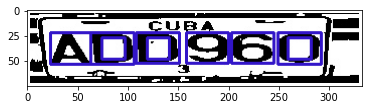

array([[[          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        ...,
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0]],

       [[          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,           0, ...,           0,           0,           0],
        ...,
        [          0,           0,           0, ...,           0,           0,           0],
        [          0,           0,        

In [35]:
# Reading image from disk
# img = cv2.imread('images/pakcar2.jpg')
# char = segment_characters(img)

# Reading cropped license plate image
char = segment_characters(lp_img_crop)
char

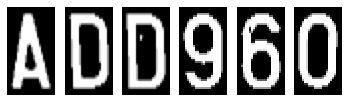

In [36]:
for i in range(len(char)):
    plt.subplot(1, len(char), i+1)
    plt.imshow(char[i], cmap='gray')
    plt.axis('off')

## Model for Characters Recognition

In [42]:
# # importing required libraries
# import json
# import tensorflow as tf
# from tensorflow.keras.models import save_model, load_model, Sequential
# from tensorflow.keras.layers import Dense, Flatten, MaxPooling2D, Dropout, Conv2D
# from tensorflow.keras import optimizers

# Importing required libraries
import json
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms


In [44]:
# # Loading model architecture
# from tensorflow.keras.preprocessing.image import ImageDataGenerator
# train_datagen = ImageDataGenerator(rescale=1./255, width_shift_range=0.1, height_shift_range=0.1)
# train_generator = train_datagen.flow_from_directory(
#         'CNN_Dataset/custom_lp_dataset/train',  # this is the target directory
#         target_size=(28,28),  # all images will be resized to 28x28
#         batch_size=1,
#         class_mode='categorical')

# validation_generator = train_datagen.flow_from_directory(
#         'CNN_Dataset/custom_lp_dataset/val',  # this is the target directory
#         target_size=(28,28),  # all images will be resized to 28x28
#         batch_size=1,
#         class_mode='categorical')


import torch
from torchvision import transforms, datasets
from torch.utils.data import DataLoader

# Define transformations, this includes resizing images to 28x28 and normalizing them
transform = transforms.Compose([
    transforms.Resize((28, 28)),  # Resize images to 28x28
    transforms.RandomHorizontalFlip(p=0.1),  # Randomly flip images horizontally
    transforms.RandomVerticalFlip(p=0.1),    # Randomly flip images vertically
    transforms.ToTensor(),  # Convert images to tensors
    transforms.Normalize((0.5,), (0.5,))  # Normalize images
])

# Setting up training data loader
train_dataset = datasets.ImageFolder('CNN_Dataset/custom_lp_dataset/train', transform=transform)
train_loader = DataLoader(train_dataset, batch_size=1, shuffle=True)

# Setting up validation data loader
validation_dataset = datasets.ImageFolder('CNN_Dataset/custom_lp_dataset/val', transform=transform)
validation_loader = DataLoader(validation_dataset, batch_size=1, shuffle=False)


In [46]:
# # Defining model
# model = Sequential()
# model.add(Conv2D(16, (22,22), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(32, (16,16), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(64, (8,8), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(Conv2D(64, (4,4), input_shape=(28, 28, 3), activation='relu', padding='same'))
# model.add(MaxPooling2D(pool_size=(4, 4)))
# model.add(Dropout(0.4))
# model.add(Flatten())
# model.add(Dense(128, activation='relu'))
# model.add(Dense(36, activation='softmax'))

# model.compile(loss='categorical_crossentropy', optimizer=optimizers.Adam(learning_rate=0.00001), metrics=['accuracy'])
# model.summary()

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torchsummary import summary

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=22, padding='same')
        self.conv2 = nn.Conv2d(16, 32, kernel_size=16, padding='same')
        self.conv3 = nn.Conv2d(32, 64, kernel_size=8, padding='same')
        self.conv4 = nn.Conv2d(64, 64, kernel_size=4, padding='same')
        self.pool = nn.MaxPool2d(4, 4)
        self.dropout = nn.Dropout(0.4)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjusted to correct flattened size
        self.fc2 = nn.Linear(128, 36)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)

# Model instantiation
model = ConvNet()

# Summary in PyTorch (requires the `torchsummary` module)
if torch.cuda.is_available():
    model.cuda()  # Move model to GPU if available
summary(model, (3, 28, 28))

# Setup optimizer and loss function
optimizer = optim.Adam(model.parameters(), lr=0.00001)
criterion = nn.CrossEntropyLoss()

# Print model architecture (similar to model.summary() in Keras)
print(model)


c:\Users\Ms Links\AppData\Local\Programs\Python\Python39\lib\site-packages\torch\nn\modules\conv.py:456: UserWarning: Using padding='same' with even kernel lengths and odd dilation may require a zero-padded copy of the input be created (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\builder\windows\pytorch\aten\src\ATen\native\Convolution.cpp:1032.)
  return F.conv2d(input, weight, bias, self.stride,


----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 16, 28, 28]          23,248
            Conv2d-2           [-1, 32, 28, 28]         131,104
            Conv2d-3           [-1, 64, 28, 28]         131,136
            Conv2d-4           [-1, 64, 28, 28]          65,600
         MaxPool2d-5             [-1, 64, 7, 7]               0
           Dropout-6             [-1, 64, 7, 7]               0
           Flatten-7                 [-1, 3136]               0
            Linear-8                  [-1, 128]         401,536
            Linear-9                   [-1, 36]           4,644
Total params: 757,268
Trainable params: 757,268
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.01
Forward/backward pass size (MB): 1.13
Params size (MB): 2.89
Estimated Total Size (MB): 4.02
-------------------------------------------

In [47]:
# # model fitting with early stopping callback to prevent overfitting
# class stop_training_callback(tf.keras.callbacks.Callback):
#   def on_epoch_end(self, epoch, logs=True):
#     # if(logs.get('val_acc') > 0.992):
#     val_acc = logs.get('val_acc')
#     print(logs)
#     if val_acc and val_acc > 0.98:
#       self.model.stop_training = True

# import datetime
# log_dir="logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
# tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
# batch_size = 1
# callbacks = [tensorboard_callback, stop_training_callback()]

# history = model.fit(
#       train_generator,
#       steps_per_epoch = train_generator.samples // batch_size,
#       validation_data = validation_generator, 
#       validation_steps = validation_generator.samples // batch_size,
#       epochs = 2, callbacks=callbacks)


import torch
from torch.utils.data import DataLoader
from torch.utils.tensorboard import SummaryWriter
import datetime
import numpy as np

# Early Stopping Callback
class EarlyStoppingCallback:
    def __init__(self, threshold=0.98):
        self.threshold = threshold

    def __call__(self, val_acc):
        if val_acc > self.threshold:
            return True
        return False

# Setup TensorBoard
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
writer = SummaryWriter(log_dir)

# Training settings
batch_size = 1
n_epochs = 2
early_stopping = EarlyStoppingCallback()

# Training loop
for epoch in range(n_epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

    avg_train_loss = running_loss / len(train_loader)
    writer.add_scalar('Loss/Train', avg_train_loss, epoch)

    # Validation phase
    model.eval()
    running_val_acc = 0.0
    with torch.no_grad():
        for inputs, labels in validation_loader:
            outputs = model(inputs)
            _, predicted = torch.max(outputs, 1)
            running_val_acc += (predicted == labels).sum().item()

    val_acc = running_val_acc / len(validation_loader.dataset)
    writer.add_scalar('Accuracy/Val', val_acc, epoch)

    print(f'Epoch {epoch+1}, Train Loss: {avg_train_loss:.4f}, Val Acc: {val_acc:.4f}')

    # Check for early stopping
    if early_stopping(val_acc):
        print("Stopping training early due to high validation accuracy.")
        break

writer.close()


Epoch 1, Train Loss: 3.1049, Val Acc: 0.4694
Epoch 2, Train Loss: 1.8743, Val Acc: 0.6463


### Saving and Loading the Model

In [57]:
# # Saving model to disk
# save_model(model, "updated_tfkmodel.keras")
# model.save('new_model.keras')

# # Save History
# import numpy as np
# model_history = {key: np.array(value).tolist() for key, value in history.history.items()}
# import json
# with open('history.json', 'w') as f:
#     json.dump(model_history, f)

import torch
import json
import numpy as np

# Saving the entire model
torch.save(model, 'new_modelpytorch.pth')

# Recommended: Save only the model state dictionary
torch.save(model.state_dict(), 'updated_model_state_dictpytorch.pth')

# saving the model history in a json file
model_history = {key: np.array(value).tolist() for key, value in history.history.items()}
with open('history.json', 'w') as f:
    json.dump(model_history, f)


In [62]:
# # loading trained model from disk
# model = load_model('updated_tfkmodel.keras')
# model.summary()

# # Loading History
# with open('history.json', 'r') as f:
#     load_model_history = json.load(f)
# loaded_history = {key: np.array(value) for key, value in load_model_history.items()}

class ConvNet(nn.Module):
    def __init__(self):
        super(ConvNet, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, kernel_size=22, padding='same')
        self.conv2 = nn.Conv2d(16, 32, kernel_size=16, padding='same')
        self.conv3 = nn.Conv2d(32, 64, kernel_size=8, padding='same')
        self.conv4 = nn.Conv2d(64, 64, kernel_size=4, padding='same')
        self.pool = nn.MaxPool2d(4, 4)
        self.dropout = nn.Dropout(0.4)
        self.flatten = nn.Flatten()
        self.fc1 = nn.Linear(64 * 7 * 7, 128)  # Adjusted to correct flattened size
        self.fc2 = nn.Linear(128, 36)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = F.relu(self.conv3(x))
        x = F.relu(self.conv4(x))
        x = self.pool(x)
        x = self.dropout(x)
        x = self.flatten(x)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.log_softmax(x, dim=1)
    
# Load the model
model = ConvNet()
model.load_state_dict(torch.load('updated_model_state_dictpytorch.pth'))
model.eval()

# Load the history
with open('history.json', 'r') as f:
    load_model_history = json.load(f)

loaded_history = {key: np.array(value) for key, value in load_model_history.items()}

### Model Evaluation

In [63]:
# # evaluate the model
# scores = model.evaluate(validation_generator, verbose=0)
# print("%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

import torch

# Set the model to evaluation mode
model.eval()

# Disable gradient computation
with torch.no_grad():
    correct = 0
    total = 0

    # Iterate over validation data
    for images, labels in validation_loader:
        # Assuming your model and data are on the same device, CPU or GPU
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

    # Calculate accuracy
    accuracy = 100 * correct / total

print("Accuracy: %.2f%%" % accuracy)

Accuracy: 63.76%


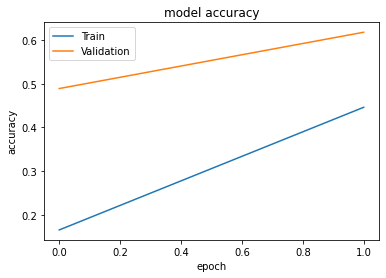

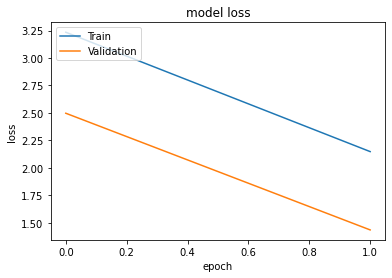

In [19]:
import matplotlib.pyplot as plt

# summarize history for accuracy
plt.plot(loaded_history['accuracy'])
plt.plot(loaded_history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(loaded_history['loss'])
plt.plot(loaded_history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['Train', 'Validation'], loc='upper left')
plt.show()

## Infer Characters From The Image

In [65]:
# # Preprocess input image for character prediction
# def fix_dimension(img): 
#   new_img = np.zeros((28,28,3))
#   for i in range(3):
#     new_img[:,:,i] = img
#   return new_img


# def show_results():
#     dic = {}
#     characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
#     for i,c in enumerate(characters):
#         dic[i] = c

#     output = []
#     for i,ch in enumerate(char): # iterating over the characters
#         img_ = cv2.resize(ch, (28,28))
#         img = fix_dimension(img_)
#         img = img.reshape(1,28,28,3) # preparing image for the model
#         # y_ = model.predict_classes(img)[0] # predicting the class
#         predict_x= model.predict(img)
#         classes_x = int(np.argmax(predict_x, axis=1)[0])
#         character = dic[classes_x] #
#         output.append(character) # storing the result in a list
        
#     plate_number = ''.join(output)
    
#     return plate_number
# lp_number = show_results()
# print(lp_number)


import torch
import numpy as np
import cv2

# Function to fix the dimension of the images to match the input expected by the network
def fix_dimension(img):
    new_img = np.zeros((28, 28, 3))
    for i in range(3):
        new_img[:, :, i] = img
    return new_img

# Function to preprocess and predict the character from each image slice
def show_results():
    dic = {}
    characters = '0123456789ABCDEFGHIJKLMNOPQRSTUVWXYZ'
    for i, c in enumerate(characters):
        dic[i] = c

    output = []
    for i, ch in enumerate(char):  # iterating over the characters
        img_ = cv2.resize(ch, (28, 28))
        img = fix_dimension(img_)
        img = np.transpose(img, (2, 0, 1))  # Change HWC to CHW
        img = torch.tensor(img, dtype=torch.float32).unsqueeze(0)  # Add batch dimension and convert to tensor
        img /= 255.0  # Normalize the image to 0-1

        # Forward pass through the model
        model.eval()  # Set the model to evaluation mode
        with torch.no_grad():
            outputs = model(img)
            predicted_index = outputs.argmax(1).item()  # Get the index of the max log-probability
            character = dic[predicted_index]
            output.append(character)  # Store the result in a list

    plate_number = ''.join(output)
    return plate_number

# Assuming 'char' is a list of image slices you want to process
lp_number = show_results()
print(lp_number)

ADD88D


In [66]:
print(f"Recognized license plate characters: {lp_number}") # detected license plate

Recognized license plate characters: ADD88D


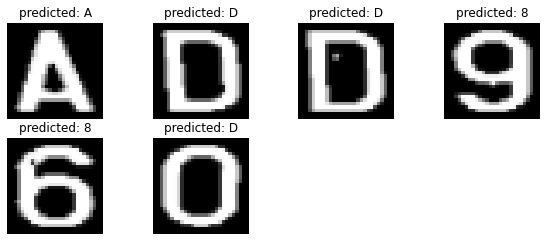

In [67]:
# Displaying segmented and recognized characters along with predicted labels
plt.figure(figsize=(10,6))
for i,ch in enumerate(char):
    img = cv2.resize(ch, (28,28))
    plt.subplot(3,4,i+1)
    plt.imshow(img,cmap='gray')
    plt.title(f'predicted: {lp_number[i]}')
    plt.axis('off')
plt.show()


0: 480x640 1 train, 176.7ms
Speed: 5.3ms preprocess, 176.7ms inference, 4.0ms postprocess per image at shape (1, 3, 480, 640)

0: 480x640 1 license_plate, 153.7ms
Speed: 6.0ms preprocess, 153.7ms inference, 1.0ms postprocess per image at shape (1, 3, 480, 640)
Distance between contours 1 and 2: 0
if (distance <= 15):
Distance between contours 2 and 3: 2
if (distance <= 15):
Distance between contours 3 and 4: 7
if (distance <= 15):
Distance between contours 4 and 5: 3
if (distance <= 15):
Distance between contours 5 and 6: 4
if (distance <= 15):
Last contour


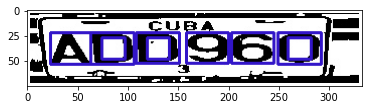

Recognized license plate characters: ADD88D


In [68]:
#test the image with the model
img = cv2.imread('download.jpeg')
lp_results, lp_img_crop = process_image(img)
char = segment_characters(lp_img_crop)
lp_number = show_results()
# print the recognized license plate
print(f"Recognized license plate characters: {lp_number}")